(cellular-structure:data-integration)=
# Data integration
```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: cellular-structure-integration-key-takeaway-1
:link-type: ref
Visualize your data before attempting to correct for batch effects to assess the extent of the issue.
Batch effect correction is not always required and it might mask the biological variation of interest.
:::

:::{card}
:link: cellular-structure-integration-key-takeaway-2
:link-type: ref
If cell labels are available and biological variation is the most important, the usage of methods that can use these labels (such as scANVI) is advised.
:::

:::{card}
:link: cellular-structure-integration-key-takeaway-3
:link-type: ref
Consider running several integration methods on your dataset and evaluating them with the **scIB** metrics to use the integration that is most robust for your use case.
:::

```
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} integration.yml
:language: yaml
```
````

`````
``````
````{dropdown} <i class="fa-solid fa-database"></i>   Get data and notebooks
```{include} ../_static/default_text_lamindb_setup.md
```
````
<!-- END DROPDOWNS -->


(cellular-structure-integration-key-takeaway-1)=
## Motivation

A central challenge in most scRNA-seq data analyses is presented by batch effects.
Batch effects are changes in measured expression levels that are the result of handling cells in distinct groups or “batches”.
For example, a batch effect can arise if two labs have taken samples from the same cohort, but these samples are dissociated differently.
If Lab A optimizes its dissociation protocol to dissociate cells in the sample while minimizing the stress on them, and Lab B does not, then it is likely that the cells in the data from the group B will express more stress-linked genes (JUN, JUNB, FOS, etc. see {cite}`Van_den_Brink2017-si`) even if the cells had the same profile in the original tissue.
In general, the origins of batch effects are diverse and difficult to pin down.
Some batch effect sources might be technical, such as differences in sample handling, experimental protocols, or {term}`sequencing` depths, but biological effects such as donor variation, tissue, or sampling location are also often interpreted as a batch effect {cite}`Luecken2021-jo`.
Whether biological factors should be considered as batch effects depends on the experimental design and the question being asked.
Removing batch effects is crucial to enable joint analysis that can focus on identifying common structure in the data across batches, allowing us to perform queries across datasets.
Often, it is only after removing these effects that rare cell populations can be identified that were previously obscured by differences between batches.
Enabling queries across datasets allows us to ask questions that could not be answered by analysing individual datasets, such as _Which cell types express SARS-CoV-2 entry factors and how does this expression differ between individuals?_ {cite}`Muus2021-ti`.

When removing batch effects from omics data, one must make two central choices: (1) the method and parameterization, and (2) the batch covariate.
As batch effects can arise between groupings of cells at different levels (i.e., samples, donors, datasets, etc.), the choice of batch covariate indicates which level of variation should be retained and which level removed.
The finer the batch resolution, the more effects will be removed. However, fine batch variation is also more likely to be confounded with biologically meaningful signals.
For example, samples typically come from different individuals or different locations in the tissue.
These effects may be worth examining.
Thus, the choice of batch covariate will depend on the goal of your integration task.
Do you want to see differences between individuals, or are you focused on common variations within cell types?
An approach to batch covariate selection based on quantitative analyses was pioneered in a recent effort to build an integrated atlas of the human lung, where the variance attributable to different technical covariates was used to make this choice {cite}`Sikkema2022-tk`.

(cellular-structure-integration-key-takeaway-2)=
### Types of integration models

Methods that remove batch effects in scRNA-seq are typically composed of (up to) three steps:
1. Dimensionality reduction
2. Modeling and removing the batch effect
3. Projection back into a high-dimensional space

While modeling and removing the batch effect (Step 2) is the central part of any batch removal method, many methods first project the data to a lower dimensional space (Step 1) to improve the signal-to-noise ratio (see the {ref}`dimensionality reduction chapter <pre-processing:dimensionality-reduction>`) and perform batch correction in that space to achieve better performance (see {cite}`Luecken2021-jo`).
In the third step, a method may project the data back into the original high-dimensional feature space after removing the fitted batch effect, thereby outputting a batch-corrected gene expression matrix.

Batch-effect removal methods can vary in each of these three steps.
They may use various linear or non-linear dimensionality reduction approaches, linear or non-linear batch effect models, and output different formats of batch-corrected data.
Overall, we can divide methods for batch effect removal into 4 categories.
In their order of development, these are global models, linear embedding models, graph-based methods, and deep learning approaches (Fig. I1).

**Global models** originate from bulk transcriptomics and model the batch effect as a consistent (additive and/or multiplicative) effect across all cells.
A common example is ComBat {cite}`Johnson2007-sl`.

**Linear embedding models** were the first single-cell-specific batch removal methods.
These approaches often use a variant of singular value decomposition (SVD) to embed the data, then look for local neighborhoods of similar cells across batches in the embedding, which they use to correct the batch effect in a locally adaptive (non-linear) manner.
Methods often project the data back into gene expression space using the SVD loadings, but may also only output a corrected embedding.
This is the most common group of methods and prominent examples include the pioneering mutual nearest neighbors (MNN) method {cite}`Haghverdi2018-bd` (which does not perform any dimensionality reduction), Seurat integration {cite}`Butler2018-js,Stuart2019-lq`, Scanorama {cite}`Hie2019-er`, FastMNN {cite}`Haghverdi2018-bd`, and Harmony {cite}`Korsunsky2019-ex`.

**Graph-based methods** are typically the fastest methods to run.
These approaches use a nearest-neighbor graph to represent the data from each batch.
Batch effects are corrected by forcing connections between cells from different batches and then allowing for differences in cell type compositions by pruning the forced edges.
The most prominent example of these approaches is the Batch-Balanced _k_-Nearest Neighbor (BBKNN) method {cite}`Polanski2019-zy`.

**Deep learning (DL) approaches** are the most recent, and most complex methods for batch effect removal that typically require the most data for good performance.
Most deep learning integration methods are based on autoencoder networks, where either the dimensionality reduction is conditioned on the batch covariate in a conditional variational autoencoder (CVAE) or a locally linear correction is fitted in the embedded space.
Prominent examples of DL methods are **scVI** {cite}`Lopez2018-au`, **scANVI** {cite}`Xu2021-dh`, and **scGen** {cite}`Lotfollahi2019-cy`.

Some methods can use cell identity labels to provide the method with a reference for what biological variation should not be removed as a batch effect.
As batch-effect removal is typically a preprocessing task, such approaches may not be applicable to many integration scenarios, as labels are generally not yet available at this stage.

More detailed overviews of batch-effect removal methods can be found in {cite}`Argelaguet2021-pb` and {cite}`Luecken2021-jo`.

![Overview_fig](figures/integration_overview_figure.jpeg)
Fig. I1: Overview of different types of integration methods with examples.

### Batch removal complexity

The removal of batch effects in scRNA-seq data has previously been divided into two subtasks: batch correction and data integration {cite}`Luecken2019-og`.
These subtasks differ in the complexity of the batch effect that must be removed.
Batch correction methods address batch effects between samples in the same experiment, where cell identity compositions are consistent, and the effect is often quasi-linear.
In contrast, data integration methods deal with complex, often nested, batch effects between datasets that may be generated using different protocols, where cell identities may not be shared across batches.
While we use this distinction here, it is worth noting that these terms are often used interchangeably in general usage.
Given the differences in complexity, it is not surprising that different methods have been benchmarked as being optimal for these two subtasks.

(cellular-structure-integration-key-takeaway-3)=
### Comparisons of data integration methods

Several benchmarks have previously evaluated the performance of methods for batch correction and data integration.
When removing batch effects, methods may overcorrect and remove meaningful biological variation in addition to the batch effect.
For this reason, it is important that integration performance is evaluated by considering both batch effect removal and the conservation of biological variation.

The _k_-nearest-neighbor Batch-Effect Test (kBET) was the first metric for quantifying batch correction of scRNA-seq data  {cite}`Buttner2019-yl`.
Using kBET, the authors found that **ComBat** outperformed other approaches for batch correction while comparing predominantly global models.
Building on this, two recent benchmarks {cite}`Tran2020-ia` and {cite}`Chazarra-Gil2021-ri` also benchmarked linear-embedding and deep-learning models on batch correction tasks with few batches or low biological complexity.
These studies found that the linear-embedding models **Seurat** {cite}`Butler2018-js,Stuart2019-lq` and **Harmony** {cite}`Korsunsky2019-ex` performed well for simple batch correction tasks.

Benchmarking complex integration tasks poses additional challenges due to both the size and number of datasets, as well as the diversity of scenarios.
Recently, a large study used 14 metrics to benchmark 16 methods across integration method classes on five RNA tasks and two simulations {cite}`Luecken2021-jo`.
While top-performing methods varied by task, approaches that utilized cell type labels performed better across tasks.
Furthermore, deep learning approaches **scANVI** (with labels), **scVI**, and **scGen** (with labels), as well as the linear embedding model **Scanorama,** performed best, particularly on complex tasks, while **Harmony** performed well on less complex tasks.
A similar benchmark performed for the specific purpose of integrating retina datasets to build an _ocular mega-atlas_ also found that **scVI** outperformed other methods {cite}`Swamy2021-uy`.


### Choosing an integration method

While integration methods have now been extensively benchmarked, an optimal method for all scenarios does not exist.
Packages of integration performance metrics and evaluation pipelines like [**scIB**](https://github.com/theislab/scib) and [**batchbench**](https://github.com/cellgeni/batchbench) can be used to evaluate integration performance on your own data.
However, many metrics (particularly those that measure the conservation of biological variation) require ground-truth cell identity labels.
Parameter optimization may tune many methods to work for particular tasks, yet in general, one can say that **Harmony** and **Seurat** consistently perform well for simple batch correction tasks, and **scVI**, **scGen**, **scANVI**, and **Scanorama** perform well for more complex data integration tasks.
When choosing a method, we recommend considering these options first.
Additionally, frameworks like [**Open Problems**](https://openproblems.bio) provide benchmarking platforms, including a leaderboard with results from various tasks such as batch integration {cite}`lueckenDefiningBenchmarkingOpen2025`.

Furthermore, the choice of integration method may be guided by the required output data format (i.e., do you need corrected gene expression data or does an integrated embedding suffice?).
It would be prudent to test multiple methods and evaluate the outputs based on quantitative definitions of success before selecting one.
Extensive guidelines for choosing a data integration method can be found in {cite}`Luecken2021-jo`.

In the rest of this chapter, we demonstrate some of the best-performing methods and quickly demonstrate how integration performance can be evaluated.

Let's silence some warnings, that will not affect our code:

In [49]:
import warnings

# This looks for any warning containing this specific text
warnings.filterwarnings("ignore", message=".*encoding metadata.*")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(
    "ignore", message=".*The default of observed=False is deprecated.*"
)

Now setting up the environments:

In [9]:
# Python packages
import anndata2ri
import bbknn
import lamindb as ln
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scvi

# R interface

%load_ext rpy2.ipython
anndata2ri.set_ipython_converter()

assert ln.setup.settings.instance.slug == "theislab/sc-best-practices"

ln.track("0VP4jDUT9P3E")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
→ loaded Transform('0VP4jDUT9P3E0000', key='integration.ipynb'), re-started Run('zYZOfUIlcXImvYWR') at 2026-02-16 19:19:58 UTC
→ notebook imports: anndata2ri==2.0 bbknn==1.6.0 lamindb==2.0.1 matplotlib==3.10.8 numpy==2.3.5 pandas==2.3.3 scanpy==1.11.5 scib==1.1.7 scvi-tools==1.4.1 session-info==1.0.0


Current environment dependencies are pinned to older versions of Python and Scanpy for BBKNN compatibility.
A version upgrade is planned following the upcoming integration of BBKNN into the Scanpy library.

In [10]:
%%R
# R packages
library(Seurat)

## Dataset

The dataset we will use to demonstrate data integration contains several samples of bone marrow mononuclear cells.
These samples were originally created for the Open Problems in Single-Cell Analysis [NeurIPS Competition 2021](https://openproblems.bio/neurips_2021/) {cite}`Luecken2022-kv,Lance2022-yy`.
The [10x Multiome](https://www.10xgenomics.com/products/single-cell-multiome-atac-plus-gene-expression) protocol was used which measures both RNA expression (scRNA-seq) and chromatin accessibility (scATAC-seq) in the same cells.
The version of the data we use here was already pre-processed to remove low-quality cells.

Let's read in the dataset using **scanpy** to get an `AnnData` object.

In [11]:
af = ln.Artifact.get(
    key="cellular_structure/openproblems_bmmc_multiome_genes_filtered.h5ad",
    is_latest=True,
)
adata_raw = af.load()
adata_raw.layers["logcounts"] = adata_raw.X
adata_raw

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

The full dataset contains 69,249 cells and measurements for 129,921 features.
There are two versions of the expression matrix, `counts`, which contains the raw count values, and `logcounts`, which contains normalized log counts (these values are also stored in `adata.X`).

The `obs` slot contains several variables, some of which were calculated during pre-processing (for quality control) and others that contain metadata about the samples.
The ones we are interested in here are:

* `cell_type` - The annotated label for each cell
* `batch` - The sequencing batch for each cell

For a real analysis, it would be important to consider more variables, but to keep it simple here, we will only look at these.

We define variables to hold these names so that it is clear how we are using them in the code.
This also helps with reproducibility because if we decide to change one of them for whatever reason, we can be sure it has changed throughout the entire notebook.

In [12]:
label_key = "cell_type"
batch_key = "batch"

```{admonition} What to use as the batch label?

As mentioned above, deciding what to use as a "batch" for data integration is one of the central choices when integrating your data.
The most common approach is to define each sample as a batch (as we have here), which generally produces the strongest batch correction.
However, samples are usually confounded with biological factors that you may want to preserve.
For example, consider an experiment that collected samples from two locations within a tissue.
If samples are considered as batches, then data integration methods will attempt to remove differences between them and therefore differences between the locations.
In this case, it may be more appropriate to use the donor as the batch to remove differences between individuals but not between locations.
The planned analysis should also be considered.
In cases where you are integrating many datasets and want to capture differences between individuals, the dataset may be a useful batch covariate.
In our example, it may be better to have consistent cell type labels for the two locations and then test for differences between them than to have separate clusters for each location, which need to be annotated separately and then matched.

The issue of confounding between samples and biological factors can be mitigated through careful experimental design that minimizes the batch effect overall by using multiplexing techniques that allow biological samples to be combined into a single sequencing sample.
However, this is not always possible and requires both extra processing in the lab and extra computational steps.
```

Now, let's review the batches and their cell counts.

In [13]:
adata_raw.obs[batch_key].value_counts()

batch
s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: count, dtype: int64

There are 13 different batches in the dataset.
During this experiment, multiple samples were taken from a set of donors and sequenced at different facilities so the names here are a combination of the sample number (eg. "s1") and the donor (eg. "d2").
For simplicity, and to reduce computational time, we will select three samples to use.

In [14]:
keep_batches = ["s1d3", "s2d1", "s3d7"]
adata = adata_raw[adata_raw.obs[batch_key].isin(keep_batches)].copy()
adata

AnnData object with n_obs × n_vars = 10270 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

After subsetting to select these batches we are left with 10,270 cells.

We have two annotations for the features stored in `var`:

* `feature_types` - The type of each feature (RNA or ATAC)
* `gene_id` - The gene associated with each feature

Let's have a look at the feature types.

In [15]:
adata.var["feature_types"].value_counts()

feature_types
ATAC    116490
GEX      13431
Name: count, dtype: int64

We can see that there are over 100,000 ATAC features, but only around 13,000 gene expression ("GEX") features.
Integration of multiple modalities is a complex problem that will be described in the {ref}`multimodal integration chapter <multimodal-integration:advanced-integration>`, so for now we will subset to only the gene expression features.
We also perform simple filtering to make sure we have no features with zero counts (this is necessary because by selecting a subset of samples, we may have removed all the cells that expressed a particular feature).

In [16]:
adata = adata[:, adata.var["feature_types"] == "GEX"].copy()
sc.pp.filter_genes(adata, min_cells=1)
adata

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

Because of the subsetting we also need to re-normalise the data. Here we just normalise using global scaling by the total counts per cell.

In [17]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

We will use this dataset to demonstrate integration.

Most integration methods require a single object containing all the samples and a batch variable (like we have here).
If instead, you have separate objects for each of your samples you can join them using the **anndata** `concat()` function.
See the [concatenation tutorial](https://anndata.readthedocs.io/en/stable/concatenation.html) for more details.
Similar functionality exists in other ecosystems.

```{admonition} Integrating UMI and full-length data

Integrating samples from UMI and full-length protocols can present additional challenges.
This is because full-length protocols are affected by gene-length bias (longer genes are more highly expressed), whereas UMI data is not {cite}`Phipson2017-qt`.
Because of this, it is generally recommended to transform counts for full-length samples into a unit that corrects for gene-length (such as transcripts per million (TPM) {cite}`Wagner2012-qf`) before attempting integration.
This isn't necessary, however, if all the samples being integrated used a full-length protocol.
```

## Unintegrated data

It is always recommended to look at the raw data before performing any integration.
This can provide some indication of the magnitude of any batch effects and what might be causing them (and therefore which variables to consider as the batch label).
For some experiments, it might even suggest that integration is not required if samples already overlap.
This is not uncommon for mouse or cell line studies from a single lab, for example, where most of the variables that contribute to batch effects can be controlled (i.e., the batch correction setting).

We will perform highly variable gene (HVG) selection, PCA, and UMAP dimensionality reduction as we have seen in previous chapters.

In [18]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

This adds several new items to our AnnData object.
The `var` slot now includes means, dispersions and the selected variable genes.
In the `obsp` slot we have distances and connectivities for our KNN graph and in `obsm` are the PCA and UMAP embeddings.

Let's plot the UMAP, colouring the points by cell identity and batch labels.
If the dataset had not already been labelled (which is often the case) we would only be able to consider the batch labels.

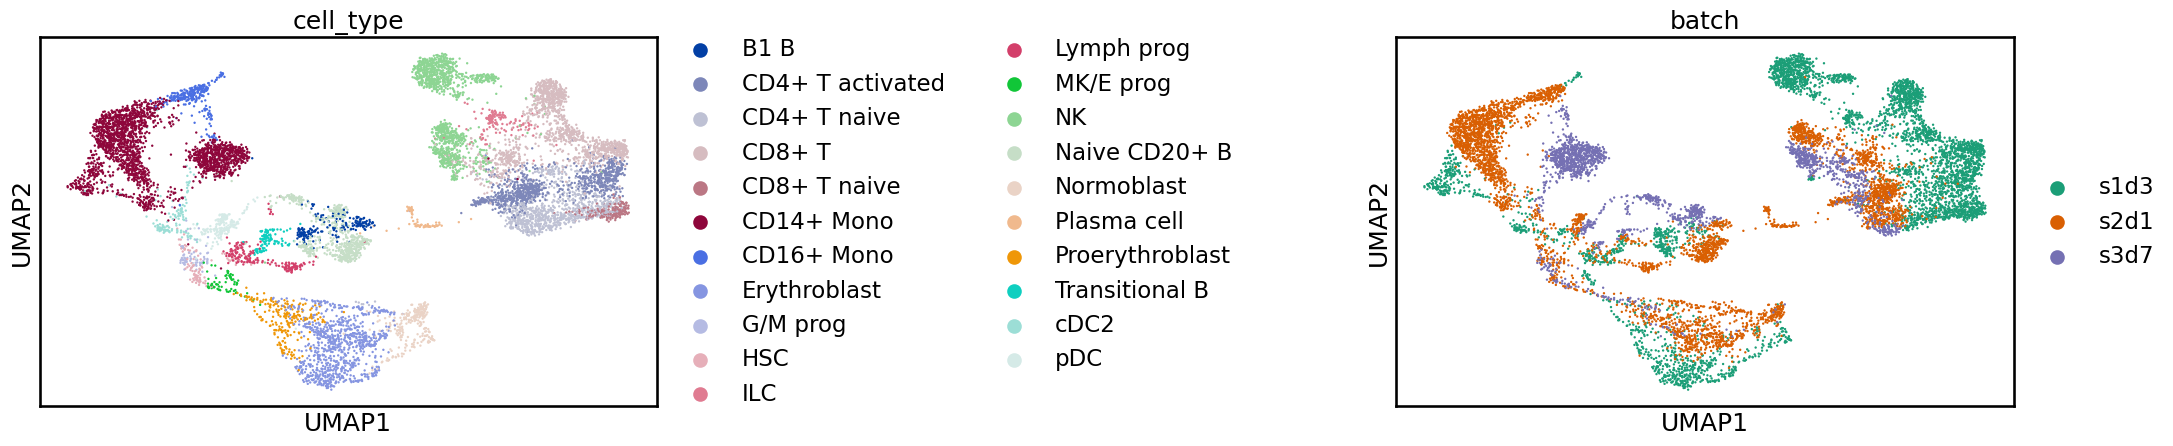

In [19]:
adata.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
]  # Set custom colours for batches
sc.pl.umap(adata, color=[label_key, batch_key], wspace=1)

Often, when examining these plots, you will notice a clear separation between batches.
In this case, what we see is more subtle, and while cells from the same label are generally near each other, there is a shift between batches.
If we were to perform a clustering analysis using this raw data, we would probably end up with some clusters containing a single batch, which would be difficult to interpret at the annotation stage.
We are also likely to overlook rare cell types that are not common enough in any single sample to produce their own cluster.
While UMAPs can often display batch effects, it is always important, when considering these 2D representations, not to overinterpret them.
For a real analysis, you should confirm the integration in other ways, such as by inspecting the distribution of marker genes.
In the “Benchmarking your own integration” section below, we discuss metrics for quantifying the quality of an integration.

Now that we have confirmed the presence of batch effects that need to be corrected, we can proceed to the various integration methods.
If the batches perfectly overlaid each other, or we could discover meaningful cell clusters without correction, then there would be no need to perform integration.

## Batch-aware feature selection

As shown in {ref}previous chapters <pre-processing:feature-selection>, we often select a subset of genes to use for our analysis in order to reduce noise and processing time.
We follow the same approach when we have multiple samples; however, it is crucial that gene selection is performed in a batch-aware manner.
This is because genes that are variable across the whole dataset could be capturing batch effects rather than the biological signals we are interested in.
It also helps to select genes relevant to rare cell identities.

For example, if an identity is only present in one sample, then markers for it may not be variable across all samples, but should be present in that one sample.

We can perform batch-aware highly variable gene selection by setting the batch_key argument in the **scanpy** highly_variable_genes() function.
**scanpy** will then calculate HVGs for each batch separately and combine the results by selecting those genes that are highly variable in the highest number of batches.
We use the **scanpy** function here because it has built-in batch awareness.
For other methods, we would have to run them on each batch individually and then manually combine the results.

In [20]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)
adata.var

,feature_types,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
AL627309.5,GEX,ENSG00000241860,112,False,0.006533,0.775289,0.357974,1,False
LINC01409,GEX,ENSG00000237491,422,False,0.024462,0.716935,-0.126119,0,False
LINC01128,GEX,ENSG00000228794,569,False,0.030714,0.709340,-0.296701,0,False
NOC2L,GEX,ENSG00000188976,675,False,0.037059,0.704363,-0.494025,0,False
KLHL17,GEX,ENSG00000187961,88,False,0.005295,0.721757,-0.028456,0,False
...,...,...,...,...,...,...,...,...,...
MT-ND5,GEX,ENSG00000198786,4056,False,0.269375,0.645837,-0.457491,0,False
MT-ND6,GEX,ENSG00000198695,1102,False,0.051506,0.697710,-0.248421,0,False
MT-CYB,GEX,ENSG00000198727,5647,False,0.520368,0.613233,-0.441362,0,False
AL592183.1,GEX,ENSG00000273748,732,False,0.047486,0.753417,0.413699,0,False


We can see there are now some additional columns in `var`:

* `highly_variable_nbatches` - The number of batches where each gene was found to be highly variable
* `highly_variable_intersection` - Whether each gene was highly variable in every batch
* `highly_variable` - Whether each gene was selected as highly variable after combining the results from each batch

Let's check how many batches each gene was variable in:

highly_variable_nbatches
0    9931
1    1824
2     852
3     824
Name: count, dtype: int64

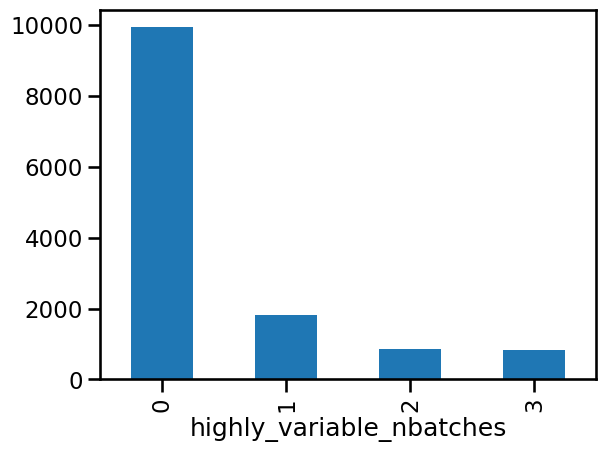

In [21]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

The first thing we notice is that most genes are not highly variable.
This is typically the case, but it can depend on how different the samples we are trying to integrate are.
The overlap then decreases as we add more samples, with relatively few genes being highly variable in all three batches.
By selecting the top 2000 genes, we have selected all HVGs that are present in two or three batches and most of those that are present in one batch.

```{admonition} How many genes to use?

This is a question that doesn't have a clear answer.
The authors of the **scvi-tools** package which we use below recommend between 1000 and 10000 genes but how many depends on the context including the complexity of the dataset and the number of batches.
A survey from a previous best practices paper {cite}`Luecken2019-og` indicated people typically use between 1000 and 6000 HVGs in a standard analysis. While selecting fewer genes can aid in the removal of batch effects {cite}`Luecken2021-jo` (the most highly-variable genes often describe only dominant biological variation), we recommend selecting slightly too many genes rather than selecting too few and risk removing genes that are important for a rare cell type or a pathway of interest.
It should, however, be noted that more genes will also increase the time required to run the integration methods.
```

We will create an object with just the selected genes to use for integration.

In [22]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'co

## Variational autoencoder (VAE) based integration

The first integration method we will use is **scVI** (single-cell Variational Inference), a method based on a conditional variational autoencoder {cite}`Lopez2018-au` available in the **scvi-tools** package {cite}`Gayoso2022-ar`.
A [variational autoencoder](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) is a type of artificial neural network that attempts to reduce the dimensionality of a dataset.
The conditional part refers to conditioning this dimensionality reduction process on a particular covariate (in this case, batches) such that the covariate does not affect the low-dimensional representation.
In benchmarking studies **scVI** has been shown to perform well across a range of datasets with a good balance of batch correction while conserving biological variability {cite}`Luecken2021-jo`.
**scVI** models raw counts directly, so it is important that we provide it with a count matrix rather than a normalized expression matrix.

First, let's make a copy of our dataset to use for this integration.
Normally, it is not necessary to do this, but as we will demonstrate multiple integration methods, making a copy makes it easier to show what has been added by each method.

In [23]:
adata_scvi = adata_hvg.copy()

### Data preparation

The first step in using **scVI** is to prepare our AnnData object.
This step stores some information required by **scVI** such as which expression matrix to use and what the batch key is.

In [24]:
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pc

The fields created by **scVI** are prefixed with `_scvi`.
These are designed for internal use and should not be manually modified.
The general advice from the **scvi-tools** authors is not to make any changes to our object until after the model is trained.
On other datasets, you may see a warning about the input expression matrix containing unnormalised count data.
This usually means you should check that the layer provided to the setup function does actually contain count values but it can also happen if you have values from performing gene length correction on data from a full-length protocol or from another quantification method that does not produce integer counts.

### Building the model

We can now construct an **scVI** model object.
As well as the **scVI** model we use here, the **scvi-tools** package contains various other models (we will use the **scANVI** model below).

In [25]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

The **scVI** model object contains the provided AnnData object as well as the neural network for the model itself.
You can see that currently the model is not trained.
If we wanted to modify the structure of the network, we could provide additional arguments to the model construction function, but here we just use the defaults.

We can also print a more detailed description of the model that shows us where things are stored in the associated AnnData object.

In [26]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.4.1.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   3   │
│         n_cells          │ 10270 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d3    │          0          │
│                    │    s2d1    │          1          │
│                    │    s3d7    │          2          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

Here we can see exactly what information has been assigned by **scVI**, including details like how each different batch is encoded in the model.

### Training the model

The model will be trained for a given number of _epochs_, a training iteration where every cell is passed through the network.
By default **scVI** uses the following heuristic to set the number of epochs.
For datasets with fewer than 20,000 cells, 400 epochs will be used, and as the number of cells grows above 20,000, the number of epochs is continuously reduced.
The reasoning behind this is that as the network sees more cells during each epoch, it can learn the same amount of information as it would from more epochs with fewer cells.

In [27]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
print(max_epochs_scvi)

400


We now train the model for the selected number of epochs (this will take ~20-40 minutes depending on the computer you are using).

In [28]:
model_scvi.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/seohyon/miniconda3/envs/integration/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [27:37<00:00,  3.98s/it, v_num=1, train_loss=645]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [27:37<00:00,  4.14s/it, v_num=1, train_loss=645]


```{admonition} Early stopping

In addition to setting a target number of epochs, it is also possible to set `early_stopping=True` in the training function.
This will let **scVI** decide to stop training early depending on the convergence of the model.
The exact conditions for stopping can be controlled by other parameters.
```

### Extracting the embedding 

The main result we want to extract from the trained model is the latent representation for each cell.
This is a multi-dimensional embedding where the batch effects have been removed, which can be used in a similar way to how we use PCA dimensions when analysing a single dataset.
We store this in `obsm` with the key `X_scvi`.

In [29]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

### Calculate a batch-corrected UMAP

We will now visualise the data as we did before integration.
We calculate a new UMAP embedding but instead of finding nearest neighbors in PCA space, we start with the corrected representation from **scVI**.

In [30]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pc

Once we have the new UMAP representation we can plot it colored by batch and identity labels as before.

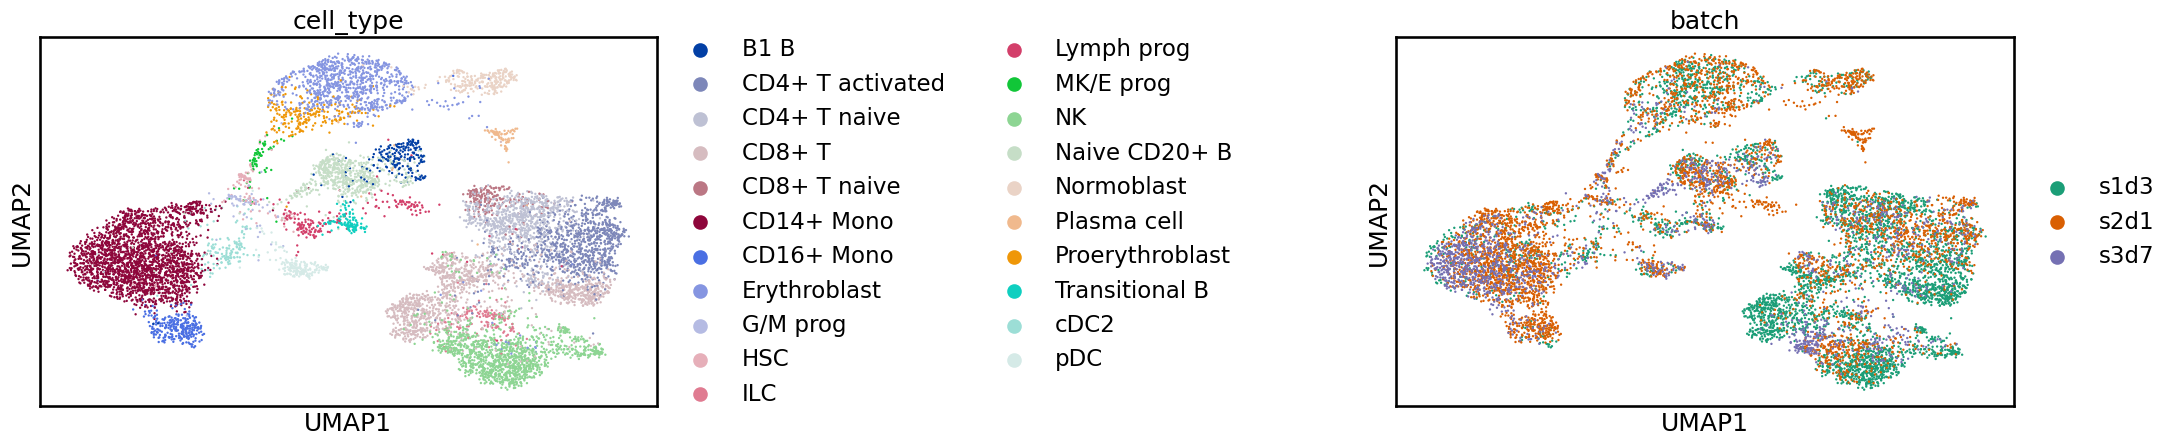

In [31]:
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)

This looks better!
Before, the various batches were shifted apart from each other.
Now, the batches overlap more, and we have a single blob for each cell identity label.

In many cases, we would not already have identity labels, so from this stage, we would continue with clustering, annotation, and further analysis as described in other chapters.

## VAE integration using cell labels

When performing integration with **scVI** we pretended that we didn't already have any cell labels (although we showed them in plots).
While this scenario is common, there are some cases where we do know something about cell identity in advance.
Most often, this is when we want to combine one or more publicly available datasets with data from a new study.
When we have labels for at least some of the cells we can use **scANVI** (single-cell ANnotation using Variational Inference) {cite}`Xu2021-dh`.
This is an extension of the **scVI** model that can incorporate cell identity label information as well as batch information.
Because it has this extra information, it can try to keep the differences between cell labels while removing batch effects.
Benchmarking suggests that **scANVI** tends to better preserve biological signals compared to **scVI** but sometimes it is not as effective at removing batch effects {cite}`Luecken2021-jo`.
While we have labels for all cells here it is also possible to use **scANVI** in a semi-supervised manner where labels are only provided for some cells.

```{admonition} Label harmonization

If you are using **scANVI** to integrate multiple datasets for which you already have labels it is important to first perform _label harmonization_.
This refers to a process of checking that labels are consistent across the datasets that are being integrated.
For example, a cell may be annotated as a "T cell" in one dataset, but a cell of the same type could have been given the label "CD8+ T cell" in another dataset.
How best to harmonize labels is an open question, but it often requires input from subject-matter experts.
```

We start by creating a **scANVI** model object.
Note that because **scANVI** refines an already trained **scVI** model, we provide the scVI model rather than an AnnData object.
If we had not already trained an **scVI** model we would need to do that first.
We also provide a key for the column of `adata.obs` which contains our cell labels as well as the label which corresponds to unlabelled cells.
In this case, all of our cells are labelled, so we just provide a dummy value.
In most cases, it is important to check that this is set correctly so that **scANVI** knows which label to ignore during training.

In [32]:
# Normally we would need to run scVI first but we have already done that here
# model_scvi = scvi.model.SCVI(adata_scvi) etc.
model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi, labels_key=label_key, unlabeled_category="unlabelled"
)
print(model_scanvi)
model_scanvi.view_anndata_setup()

ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

Anndata setup with scvi-tools version 1.4.1.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'cell_type',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'use_minified': False
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   3   │
│         n_cells          │ 10270 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  22   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d3    │          0          │
│                    │    s2d1    │          1          │
│                    │    s3d7    │          2          │
└────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │       B1 B       │          0          │
│                        │ CD4+ T activated │          1          │
│                        │   CD4+ T naive   │          2          │
│                        │      CD8+ T      │          3          │
│                        │   CD8+ T naive   │          4          │
│                        │    CD14+ Mono    │          5          │
│                        │    CD16+ Mono    │          6          │
│                        │   Erythroblast   │          7          │
│                        │     G/M prog     │          8          │
│                        │       HSC        │          9          │
│                        │       ILC        │         10          │
│                        │    Lymph prog    │         11          │
│                        │    MK/E prog     │         12          │
│                        │        NK        │         13          │
│                        │  Naive CD20+ B   │         14          │
│                        │    Normoblast    │         15          │
│                        │   Plasma cell    │         16          │
│                        │ Proerythroblast  │         17          │
│                        │  Transitional B  │         18          │
│                        │       cDC2       │         19          │
│                        │       pDC        │         20          │
│                        │    unlabelled    │         21          │
└────────────────────────┴──────────────────┴─────────────────────┘

This **scANVI** model object is very similar to what we saw before for **scVI**.
As mentioned previously, we could modify the structure of the model network but here we just use the default parameters.

Again, we have a heuristic for selecting the number of training epochs.
Note that this is much fewer than before as we are just refining the **scVI** model, rather than training a whole network from scratch.

In [33]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scanvi)

INFO     Training for 10 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/seohyon/miniconda3/envs/integration/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 10/10: 100%|██████████| 10/10 [01:06<00:00,  6.74s/it, v_num=1, train_loss=637]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [01:06<00:00,  6.61s/it, v_num=1, train_loss=637]


We can extract the new latent representation from the model and create a new UMAP embedding as we did for **scVI**.

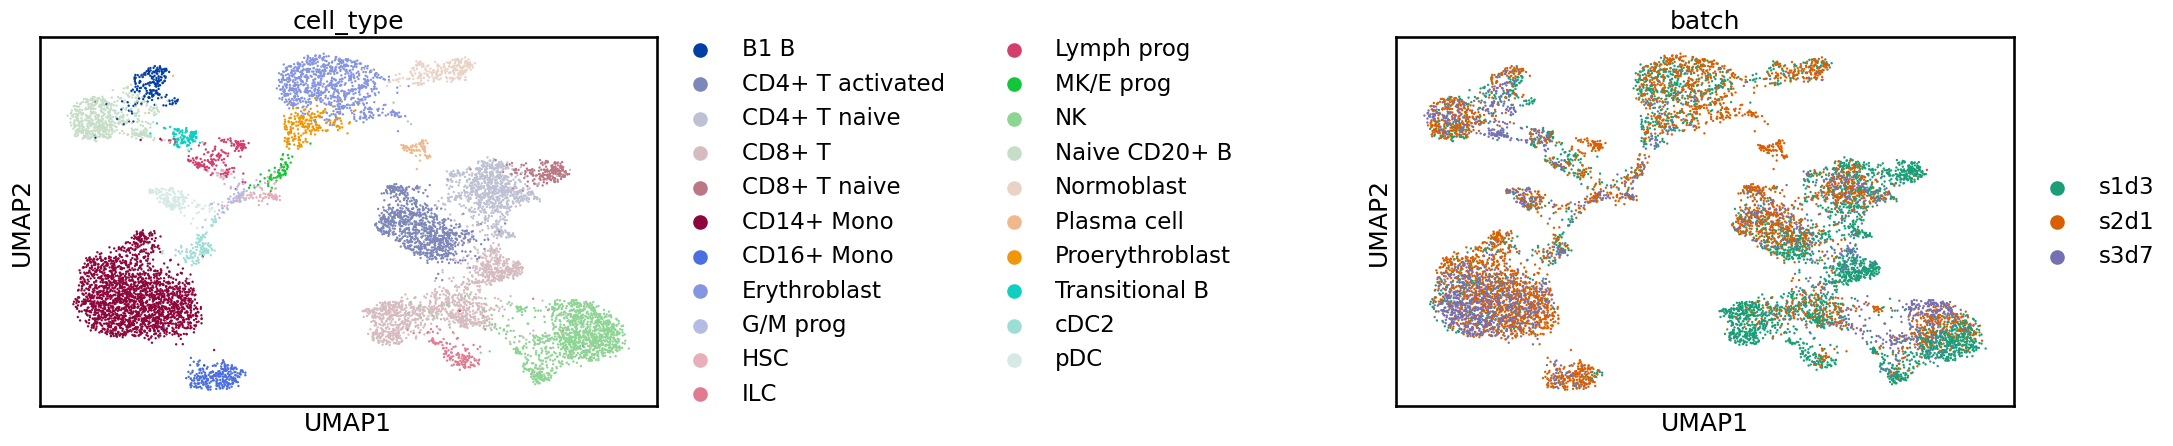

In [34]:
adata_scanvi = adata_scvi.copy()
adata_scanvi.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scanvi, use_rep="X_scANVI")
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=[label_key, batch_key], wspace=1)

By looking at the UMAP representation it is difficult to tell the difference between **scANVI** and **scVI** but as we will see below there are differences in metric scores when the quality of the integrations is quantified.
This is a reminder that we shouldn't overinterpret these two-dimensional representations, especially when comparing methods.

## Graph-based integration

The next method we will look at is **BBKNN** or "Batch Balanced KNN" {cite}`Polanski2019-zy`. This is a very different approach to **scVI**, which rather than using a neural network to embed cells in a batch corrected space, instead modifies how the _k_-nearest neighbor (KNN) graph used for clustering and embedding is constructed.
As we have seen in {ref}`previous chapters <cellular-structure:clustering>`, the normal KNN procedure connects cells to the most similar cells across the whole dataset.
The change that **BBKNN** makes is to enforce that cells are connected to cells from other batches.
While this is a simple modification, it can be quite effective, particularly when there are very strong batch effects.
However, as the output is an integrated graph, it can have limited downstream uses, as few packages will accept this as an input.

An important parameter for **BBKNN** is the number of neighbors per batch.
A suggested heuristic for this is to use 25 if there are more than 100,000 cells or the default of 3 if there are fewer than 100,000.

In [35]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 100000 else 3
neighbors_within_batch

3

Before using **BBKNN** we first perform a PCA as we would before building a normal KNN graph.
Unlike **scVI** which models raw counts here, we start with the log-normalised expression matrix.

In [36]:
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)

We can now run **BBKNN**, replacing the call to the **scanpy** `neighbors()` function in a standard workflow.
An important difference is to make sure the `batch_key` argument is set which specifies a column in `adata_hvg.obs` that contains batch labels.

In [37]:
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
adata_bbknn

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'co

Unlike the default **scanpy** function, **BBKNN** does not allow specifying a key for storing results so they are always stored under the default "neighbors" key.

We can use this new integrated graph just like we would use a normal KNN graph to construct a UMAP embedding.

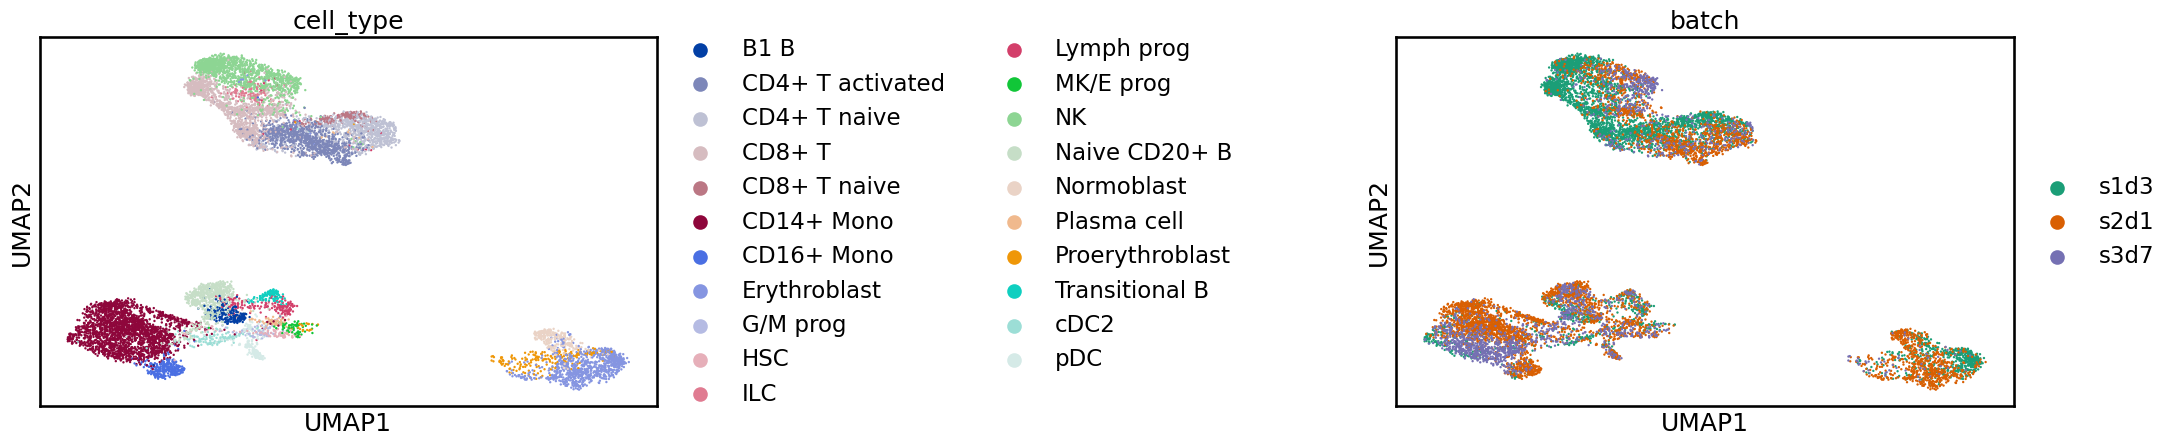

In [38]:
sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color=[label_key, batch_key], wspace=1)

This integration is also improved compared to the unintegrated data, with cell identities grouped together, but we still see some shifts between batches.

## Linear embedding integration using Mutual Nearest Neighbors (MNN)

Some downstream applications cannot accept an integrated embedding or neighborhood graph and require a corrected expression matrix.
One approach that can produce this output is the integration method in **Seurat** {cite}`Satija2015-or,Butler2018-js,Stuart2019-lq`.
The **Seurat** integration method belongs to a class of _linear embedding models_ that make use of the idea of _mutual nearest neighbors_ (which **Seurat** calls _anchors_) to correct batch effects {cite}`Haghverdi2018-bd`.
Mutual nearest neighbors are pairs of cells from two different datasets that are in the neighborhood of each other when the datasets are placed in the same (latent) space.
After finding these cells, they can be used to align the two datasets and correct the differences between them.
**Seurat** has also been found to be one of the top mixing methods in some evaluations {cite}`Tran2020-ia`.

As **Seurat** is an R package we must transfer our data from Python to R.
Here we prepare the AnnData to convert so that it can be handled by **rpy2** and **anndata2ri**.

In [39]:
adata_seurat = adata_hvg.copy()
# Convert categorical columns to strings
adata_seurat.obs[batch_key] = adata_seurat.obs[batch_key].astype(str)
adata_seurat.obs[label_key] = adata_seurat.obs[label_key].astype(str)
# Delete uns as this can contain arbitrary objects which are difficult to convert
del adata_seurat.uns
adata_seurat

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

The prepared AnnData is now available in R as a SingleCellExperiment object thanks to **anndata2ri**.
Note that this is transposed compared to an AnnData object so our observations (cells) are now the columns and our variables (genes) are now the rows.

In [40]:
%%R -i adata_seurat
adata_seurat

class: SingleCellExperiment 
dim: 2000 10270 
metadata(0):
assays(3): X counts logcounts
rownames(2000): GPR153 TNFRSF25 ... TMLHE-AS1 MT-ND3
rowData names(9): feature_types gene_id ... highly_variable_nbatches
  highly_variable_intersection
colnames(10270): TCACCTGGTTAGGTTG-3-s1d3 CGTTAACAGGTGTCCA-3-s1d3 ...
  AGCAGGTAGGCTATGT-12-s3d7 GCCATGATCCCTTGCG-12-s3d7
colData names(28): GEX_pct_counts_mt GEX_n_counts ... QCMeds
  DonorSmoker
reducedDimNames(8): ATAC_gene_activity ATAC_lsi_full ... PCA UMAP
mainExpName: NULL
altExpNames(0):


**Seurat** uses its own object to store data.
Helpfully the authors provide a function to convert from SingleCellExperiment.
We just provide the SingleCellExperiment object and tell **Seurat** which assays (layers in our AnnData object) contain raw counts and normalised expression (which **Seurat** stores in a slot called "data").

In [41]:
%%R -i adata_seurat
seurat <- as.Seurat(adata_seurat, counts = "counts", data = "logcounts")
seurat

An object of class Seurat 
2000 features across 10270 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)
 2 layers present: counts, data
 8 dimensional reductions calculated: ATAC_gene_activity, ATAC_lsi_full, ATAC_lsi_red, ATAC_umap, GEX_X_pca, GEX_X_umap, PCA, UMAP


In addition: Warning messages:
1: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 1.5 GiB
2: Keys should be one or more alphanumeric characters followed by an underscore, setting key from ATAC_gene_activity_ to ATACgeneactivity_ 
3: Keys should be one or more alphanumeric characters followed by an underscore, setting key from ATAC_lsi_full_ to ATAClsifull_ 
4: Keys should be one or more alphanumeric characters followed by an underscore, setting key from ATAC_lsi_red_ to ATAClsired_ 
5: Keys should be one or more alphanumeric characters followed by an underscore, setting key from ATAC_umap_ to ATACumap_ 
6: Keys should be one or more alphanumeric characters followed by an underscore, setting key from GEX_X_pca_ to GEXXpca_ 
7: Keys should be one or more alphanumeric characters followed by an underscore, setting key from GEX_X_umap_ to GEXXumap_ 


Unlike some of the other methods, we have seen which take a single object and a batch key, the **Seurat** integration functions require a list of objects.
We create this using the `SplitObject()` function.

In [42]:
%%R -i batch_key
batch_list <- SplitObject(seurat, split.by = batch_key)
batch_list

$s1d3
An object of class Seurat 
2000 features across 4279 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)
 2 layers present: counts, data
 8 dimensional reductions calculated: ATAC_gene_activity, ATAC_lsi_full, ATAC_lsi_red, ATAC_umap, GEX_X_pca, GEX_X_umap, PCA, UMAP

$s2d1
An object of class Seurat 
2000 features across 4220 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)
 2 layers present: counts, data
 8 dimensional reductions calculated: ATAC_gene_activity, ATAC_lsi_full, ATAC_lsi_red, ATAC_umap, GEX_X_pca, GEX_X_umap, PCA, UMAP

$s3d7
An object of class Seurat 
2000 features across 1771 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)
 2 layers present: counts, data
 8 dimensional reductions calculated: ATAC_gene_activity, ATAC_lsi_full, ATAC_lsi_red, ATAC_umap, GEX_X_pca, GEX_X_umap, PCA, UMAP



We can now use this list to find anchors for each pair of datasets.
Usually, you would identify batch-aware highly variable genes first (using the `FindVariableFeatures()` and `SelectIntegrationFeatures()` functions) but as we have done that already we tell **Seurat** to use all the features in the object.

In [43]:
%%R
anchors <- FindIntegrationAnchors(batch_list, anchor.features = rownames(seurat))
anchors

  |                                                  | 0 % ~calculating  

  |+++++++++++++++++                                 | 33% ~02s           |++++++++++++++++++++++++++++++++++                | 67% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~02m 30s       |++++++++++++++++++++++++++++++++++                | 67% ~58s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02m 46s
An AnchorSet object containing 25352 anchors between 3 Seurat objects 
 This can be used as input to IntegrateData.


Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 7195 anchors
Filtering anchors
	Retained 5146 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4619 anchors
Filtering anchors
	Retained 3588 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 5575 anchors
Filtering anchors
	Retained 3942 anchors


**Seurat** can then use the anchors to compute a transformation that maps one dataset onto another.
This is done in a pairwise way until all the datasets are merged.
By default **Seurat** will determine a merge order so that more similar datasets are merged together first but it is also possible to define this order.

In [44]:
%%R
integrated <- IntegrateData(anchors)
integrated

An object of class Seurat 
4000 features across 10270 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 layer present: data
 1 other assay present: originalexp


Merging dataset 3 into 2
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data
Merging dataset 1 into 2 3
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data


The result is another Seurat object, but notice now that the active assay is called "integrated".
This contains the corrected expression matrix which is the final output of the integration.

Here we extract that matrix and prepare it for transfer back to Python.

In [45]:
%%R -o integrated_expr
# Extract the integrated expression matrix
integrated_expr <- GetAssayData(integrated)
# Make sure the rows and columns are in the same order as the original object
integrated_expr <- integrated_expr[rownames(seurat), colnames(seurat)]
# Transpose the matrix to AnnData format
integrated_expr <- t(integrated_expr)
print(integrated_expr[1:10, 1:10])

10 x 10 sparse Matrix of class "dgCMatrix"
                                                                               
TCACCTGGTTAGGTTG-3-s1d3  .            -0.0005365199  1.032812e-02 -2.653187e-02
CGTTAACAGGTGTCCA-3-s1d3  0.0001382038 -0.1809919666 -1.454901e-02  3.608087e-03
ATTCGTTTCAGTATTG-3-s1d3 -0.0121073019 -0.0634131448  .             2.144075e-02
GGACCGAAGTGAGGTA-3-s1d3  .             .             2.972292e-04  .           
ATGAAGCCAGGGAGCT-3-s1d3 -0.0139047070 -0.0313151266  .             2.239855e-02
AGTGCGGAGTAAGGGC-3-s1d3 -0.0004299227 -0.0002657828  .            -1.871410e-03
CTACCTCAGACACCGC-3-s1d3 -0.0055208619 -0.0398862165  7.182254e-06  8.240408e-03
CTTCAATTCACGAATC-3-s1d3  .            -0.0109928444  .             1.935677e-04
CCATTGTGTAGACAAA-3-s1d3  .             0.0171909577  .             5.711312e-05
CCGTTACTCAATGTGC-3-s1d3  0.0139905520  0.0007981117  2.303345e-03  1.356206e-02
                                                                          
TC

  [[ suppressing 10 column names ‘GPR153’, ‘TNFRSF25’, ‘TNFRSF9’ ... ]]


We will now store the corrected expression matrix as a layer in our AnnData object.
We also set `adata.X` to use this matrix.

In [46]:
adata_seurat.X = integrated_expr
adata_seurat.layers["seurat"] = integrated_expr
print(adata_seurat)
adata.X

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'seurat'
    obsp: 'distances', 'connectivities'


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 14348115 stored elements and shape (10270, 13431)>

Now that we have the results of our integration we can calculate a UMAP and plot it as we have for the other methods (we could also have done this in R).

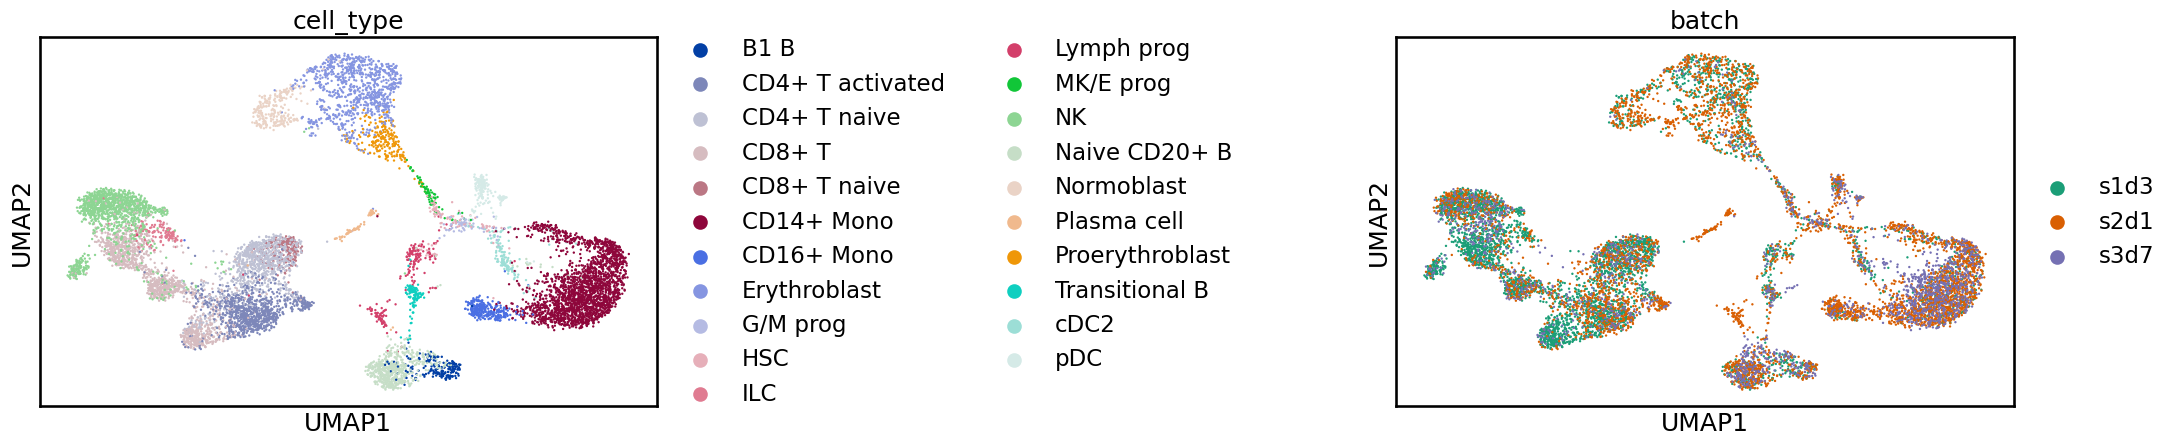

In [47]:
# Reset the batch colours because we deleted them earlier
adata_seurat.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
]
sc.tl.pca(adata_seurat)
sc.pp.neighbors(adata_seurat)
sc.tl.umap(adata_seurat)
sc.pl.umap(adata_seurat, color=[label_key, batch_key], wspace=1)

As we have previously seen, the batches are mixed while the labels are separated.
It is tempting to select an integration based on the UMAPs, but this does not fully represent the quality of an integration.
In the next section, we present some approaches to more rigorously evaluate integration methods.

```{admonition} A note on scalability

As you ran the different integration methods you may have noticed that **scVI** took the most time.
While this is true for small datasets like the example shown here, [benchmarks have shown](https://www.nature.com/articles/s41592-021-01336-8/figures/13) that **scVI** scales well for larger datasets.
This is largely because the number of training epochs is adjusted for larger dataset sizes.
MNN methods typically don't scale as well, partly because they perform several pairwise integrations, so if you have 20 batches, you are performing 20 integrations, while other methods can consider all batches at once.
```

## Benchmarking your own integration

The methods demonstrated here are selected based on results from benchmarking experiments, including the [single-cell integration benchmarking project](https://theislab.github.io/scib-reproducibility/) {cite}`Luecken2021-jo`.
This project also produced a software package called [**scib**](https://www.github.com/theislab/scib) that can be used to run a range of integration methods as well as the metrics that were used for evaluation.
In this section, we demonstrate how to utilize this package to assess the quality of an integration.

```{admonition} What is the ground truth?

Some of these metrics, particularly those that evaluate the conservation of biological variation, require a known ground truth for comparison.
Typically, this is a cell identity label, but it can also include other information, such as known trajectories.
Because of this requirement, it is difficult to evaluate integration for a completely new dataset where it is unclear what biological signal should be preserved.
```

The **scib** metrics can be run individually but there are also wrappers for running multiple metrics at once.
Here we run a subset of the metrics, which are quick to compute using the `metrics_fast()` function.
This function takes a few arguments: the original unintegrated dataset, the integrated dataset, a batch key, and a label key.
Depending on the output of the integration method we might also need to supply additional arguments, for example here we specify the embedding to use for **scVI** and **scANVI** with the `embed` argument.
You can also control how some metrics are run with additional arguments.
Also note that you may need to check that objects are formatted properly so that **scIB** can find the required information.

Let's run the metrics for each of the integrations we have performed above, as well as the unintegrated data (after highly variable gene selection).

In [50]:
metrics_scvi = scib.metrics.metrics_fast(
    adata, adata_scvi, batch_key, label_key, embed="X_scVI"
)
metrics_scanvi = scib.metrics.metrics_fast(
    adata, adata_scanvi, batch_key, label_key, embed="X_scANVI"
)
metrics_bbknn = scib.metrics.metrics_fast(adata, adata_bbknn, batch_key, label_key)
metrics_seurat = scib.metrics.metrics_fast(adata, adata_seurat, batch_key, label_key)
metrics_hvg = scib.metrics.metrics_fast(adata, adata_hvg, batch_key, label_key)

Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...


Here is an example of what one of the metrics results looks like for a single integration:

In [51]:
metrics_hvg

,0
NMI_cluster/label,NaN
ARI_cluster/label,NaN
ASW_label,0.555775
ASW_label/batch,0.833656
PCR_batch,0.000000
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.653710
graph_conn,0.985660
kBET,NaN


Each row is a different metric, and the values show the score for that metric.
Scores are between 0 and 1, where 1 is a good performance and 0 is a poor performance (**scib** can also return unscaled scores for some metrics if required).
Because we have only run the fast metrics here, some of the metrics have `NaN` scores.
Also, note that some metrics cannot be used with some output formats, which can also be a reason for `NaN` values being returned.

To compare the methods, it is useful to have all the metric results in one table.
This code combines them and tidies them into a more convenient format.

In [52]:
# Concatenate metrics results
metrics = pd.concat(
    [metrics_scvi, metrics_scanvi, metrics_bbknn, metrics_seurat, metrics_hvg],
    axis="columns",
)
# Set methods as column names
metrics = metrics.set_axis(
    ["scVI", "scANVI", "BBKNN", "Seurat", "Unintegrated"], axis="columns"
)
# Select only the fast metrics
metrics = metrics.loc[
    [
        "ASW_label",
        "ASW_label/batch",
        "PCR_batch",
        "isolated_label_silhouette",
        "graph_conn",
        "hvg_overlap",
    ],
    :,
]
# Transpose so that metrics are columns and methods are rows
metrics = metrics.T
# Remove the HVG overlap metric because it's not relevant to embedding outputs
metrics = metrics.drop(columns=["hvg_overlap"])
metrics

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn
scVI,0.567771,0.906278,0.854619,0.638646,0.981818
scANVI,0.616567,0.907695,0.747247,0.676892,0.994919
BBKNN,0.555469,0.847772,0.190583,0.641923,0.958387
Seurat,0.571231,0.915237,0.629736,0.617306,0.988407
Unintegrated,0.555775,0.833656,0.000000,0.653710,0.985660


We now have all the scores in one table with metrics as columns and methods as rows.
Styling the table with a gradient can make it easier to see the differences between scores.

In [53]:
metrics.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn
scVI,0.567771,0.906278,0.854619,0.638646,0.981818
scANVI,0.616567,0.907695,0.747247,0.676892,0.994919
BBKNN,0.555469,0.847772,0.190583,0.641923,0.958387
Seurat,0.571231,0.915237,0.629736,0.617306,0.988407
Unintegrated,0.555775,0.833656,0.000000,0.653710,0.985660


For some metrics, the scores tend to be in a relatively small range.
To emphasise the differences between methods and place each metric on the same scale, we scale them so that the worst performer gets a score of 0, the best performer gets a score of 1 and the others are somewhere in between.

In [54]:
metrics_scaled = (metrics - metrics.min()) / (metrics.max() - metrics.min())
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn
scVI,0.201355,0.890188,1.000000,0.358142,0.641394
scANVI,1.000000,0.907550,0.874363,1.000000,1.000000
BBKNN,0.000000,0.173035,0.223004,0.413133,0.000000
Seurat,0.257985,1.000000,0.736861,0.000000,0.821743
Unintegrated,0.005015,0.000000,0.000000,0.610951,0.746558


The values now better represent the differences between methods (and better match the colour scale).
However, it is important to note that the scaled scores can only be used to compare the relative performance of this specific set of integrations.
If we wanted to add another method, we would need to perform the scaling again. We also can't say that an integration is definitely "good", only that it is better than the other methods we have tried.
This scaling emphasises differences between methods.
For example, if we had metric scores of 0.92, 0.94, and 0.96, these would be scaled to 0, 0.5, and 1.0.
This makes the first method appear to score much worse, even though it is only slightly lower than the other two and still got a very high score.
This effect is bigger when comparing a few methods and when they get similar raw scores.
Whether you look at raw or scaled scores depends on whether you want to focus on absolute performance or the difference in performance between methods.

The evaluation metrics can be grouped into two categories: those that measure the removal of batch effects and those that measure the conservation of biological variation.
We can calculate summary scores for each of these categories by taking the mean of the scaled values for each group.
This type of summary score wouldn't make sense with raw values, as some metrics consistently produce higher scores than others (and therefore have a greater impact on the mean).

In [55]:
metrics_scaled["Batch"] = metrics_scaled[
    ["ASW_label/batch", "PCR_batch", "graph_conn"]
].mean(axis=1)
metrics_scaled["Bio"] = metrics_scaled[["ASW_label", "isolated_label_silhouette"]].mean(
    axis=1
)
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,Batch,Bio
scVI,0.201355,0.890188,1.000000,0.358142,0.641394,0.843861,0.279749
scANVI,1.000000,0.907550,0.874363,1.000000,1.000000,0.927304,1.000000
BBKNN,0.000000,0.173035,0.223004,0.413133,0.000000,0.132013,0.206566
Seurat,0.257985,1.000000,0.736861,0.000000,0.821743,0.852868,0.128992
Unintegrated,0.005015,0.000000,0.000000,0.610951,0.746558,0.248853,0.307983


Plotting the two summary scores against each other gives an indication of the priorities of each method.
Some will be biased towards batch correction while others will favour retaining biological variation.

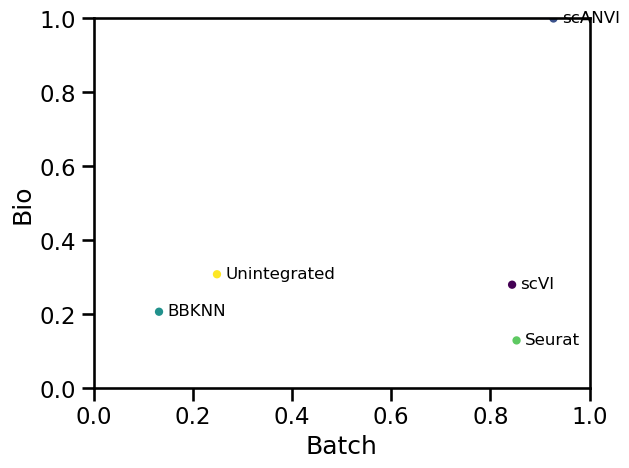

In [56]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
metrics_scaled.plot.scatter(
    x="Batch",
    y="Bio",
    c=range(len(metrics_scaled)),
    ax=ax,
)

for k, v in metrics_scaled[["Batch", "Bio"]].iterrows():
    ax.annotate(
        k,
        v,
        xytext=(6, -3),
        textcoords="offset points",
        family="sans-serif",
        fontsize=12,
    )

In our small example scenario **BBKNN** is clearly the worst performer, getting the lowest scores for both batch removal and biological conservation.
The other three methods have similar batch correction scores with **scANVI** scoring highest for biological conservation followed by **Seurat** and **scVI**.

To get an overall score for each method, we can combine the two summary scores.
The **scIB** paper suggests a weighting of 40% batch correction and 60% biological conservation but you may prefer to weight things differently depending on the priorities for your dataset.

In [57]:
metrics_scaled["Overall"] = 0.4 * metrics_scaled["Batch"] + 0.6 * metrics_scaled["Bio"]
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,Batch,Bio,Overall
scVI,0.201355,0.890188,1.000000,0.358142,0.641394,0.843861,0.279749,0.505394
scANVI,1.000000,0.907550,0.874363,1.000000,1.000000,0.927304,1.000000,0.970922
BBKNN,0.000000,0.173035,0.223004,0.413133,0.000000,0.132013,0.206566,0.176745
Seurat,0.257985,1.000000,0.736861,0.000000,0.821743,0.852868,0.128992,0.418543
Unintegrated,0.005015,0.000000,0.000000,0.610951,0.746558,0.248853,0.307983,0.284331


Let's make a quick bar chart to visualise the overall performance.

<Axes: >

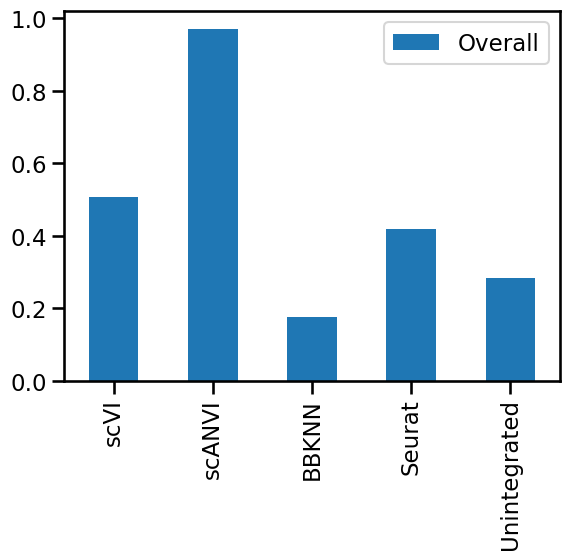

In [58]:
metrics_scaled.plot.bar(y="Overall")

As we have already seen **scANVI** is the best performer followed by **scVI** and **Seurat**.
It is important to note that this is just an example of how to run these metrics for this specific dataset, not a proper evaluation of these methods.
For that, you should refer to existing benchmarking publications.
In particular, we have only run a small selection of high-performing methods and a subset of metrics.
Also, remember that scores are relative to the methods used, so even if the methods perform almost equally well, small differences will be exaggerated.

Existing benchmarks have suggested methods that generally perform well, but performance can also be quite variable across scenarios.
For some analyses, it may be worthwhile performing your own evaluation of integration.
The **scib** package makes this process easier, but it can still be a significant undertaking, relying on a good knowledge of the ground truth and interpretation of the metrics.

## Quiz

In [59]:
%run ../src/lib.py

flip_card(
    "q1",
    "What are the sources of batch effects?",
    "e.g. Differences in sample handling, experimental protocols, factors such as donor differences, tissue heterogeneity",
)
flip_card(
    "q2",
    "What is the difference between technical and biological variation?",
    "Technical variation refers to inconsistencies arising from the experimental process itself. In contrast, biological variation encompasses intrinsic differences between samples.",
    back_font_size=15,
)
flip_card(
    "q3",
    "How does one evaluate whether the integration worked well or not? What are useful metrics for this purpose?",
    "To evaluate integration effectiveness, visualization techniques like UMAP plots help assess whether cells from different batches mix well. Quantitative metrics include graph connectivity, batch entropy mixing, and silhouette scores. Combining these methods ensures that batch effects are minimized while preserving true biological signals.",
    back_font_size=13,
)

## Session information

### Python

In [60]:
import session_info

session_info.show()

### R

In [61]:
%%R
sessioninfo::session_info()

─ Session info ───────────────────────────────────────────────────────────────
 setting  value
 version  R version 4.4.3 (2025-02-28)
 os       macOS 26.2
 system   x86_64, darwin13.4.0
 ui       unknown
 language (EN)
 collate  C.UTF-8
 ctype    C.UTF-8
 tz       Europe/Berlin
 date     2026-02-16
 pandoc   3.8.3 @ /Users/seohyon/miniconda3/envs/integration/bin/pandoc
 quarto   NA

─ Packages ───────────────────────────────────────────────────────────────────
 package              * version date (UTC) lib source
 abind                  1.4-8   2024-09-12 [1] CRAN (R 4.4.3)
 Biobase              * 2.66.0  2024-10-29 [1] Bioconductor 3.20 (R 4.4.2)
 BiocGenerics         * 0.52.0  2024-10-29 [1] Bioconductor 3.20 (R 4.4.2)
 cli                    3.6.5   2025-04-23 [1] CRAN (R 4.4.3)
 cluster                2.1.8.1 2025-03-12 [1] CRAN (R 4.4.3)
 codetools              0.2-20  2024-03-31 [1] CRAN (R 4.4.3)
 cowplot                1.2.0   2025-07-07 [1] CRAN (R 4.4.3)
 crayon              

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: int
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Luke Zappia
* Malte Lücken
* Seo H. Kim

### Reviewers

* Lukas Heumos